In [79]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Filtering

In [4]:
"""
Filters the signals based on the gradient of each phase
"""
def filterData(signalFolder="D:/SamplingResults2", sampleFile="C:/Users/rjsou/Documents/MastersDiss/newSamples.pkl", steps=128):
    filtered = []
    samples = []
    runs = []
    
    f = open(f"{sampleFile}", "rb")
    samples = pickle.load(f).astype(np.float32)
    f.close()

    for i, run in enumerate(tqdm(os.listdir(f"{signalFolder}/"))):  
        inp = []
        fail = False

        #if i == 2000:
           # break
            
        files = os.listdir(f"{signalFolder}/{run}/")

        if files != ['Disp1.csv', 'Disp2.csv']:
            continue

        for file in files:
            a = pd.read_csv(f"{signalFolder}/{run}/{file}")
            a.rename(columns = {'0':'x', '0.1': 'y'}, inplace=True)

            if a['x'].max() != 7.0:
                fail = True
                break
            
            # Interpolate curve for consistent x values
            xNew = np.linspace(0, 7, num=steps, endpoint=True)
            interped = interp1d(a['x'], a['y'], kind='cubic', fill_value="extrapolate")(xNew)
            interped[0] = 0.0
            
            # Check no sudden increases/decreases in gradient
            max_def = 0 # x when displacement is first highest
            max_def_final = 0
            min_def = 0 # x when skin fully rebounds
            step_second = 1/(7/steps) # Number of steps in each second
            
            der = 0
            for i in range(len(interped)):
                # Check x where max displacement occurs
                if interped[i] > max(interped)*0.99 and max_def == 0:
                    max_def = i/step_second
                
                if max_def != 0 and interped[i] == max(interped):
                    max_def_final = i/step_second
                
                if max_def != 0 and interped[i] == min(interped[int(max_def_final):]):
                    min_def = i/step_second
   
            #if np.all(np.diff(der) < 0):
            # Cannot be within 10% of the max before 1
            # Cannot reach rebound completely before 5.2 seconds
            if min_def-max_def_final < 0.5 or max_def < 1:
                fail = True
                break
                    
            
            # Position where x=1
            #x1_idx = int(1//(7/steps))
            # Displacement cant peak at x=1
           # if  interped[x1_idx] > m*0.98 :
             #   fail = True
             #   break
            
            #fix, ax = plt.subplots(1, 2)
            #ax[0].plot(xNew, interped)
            #a.plot(ax=ax[1], x='x', y='y')

            a = interped.astype(np.float32)
            inp.append(a)

        if not fail:
            filtered.append(inp)
            runs.append(run)
    return filtered, runs

# Get statistics of given samples

In [119]:
def getStats(signalFolder, sampleFile):
    me = []
    mse = []
    mae = []
    pts = range(50, 500, 50)

    with open(f"{sampleFile}", "rb") as f:
        samples = pickle.load(f).astype(np.float32)
    for steps in pts:
        x_interped = []
        x_origin = []
        
        current_me = []
        current_mse = []
        current_mae = []

        runs = 0
        exps = os.listdir(f"{signalFolder}/")
        exps = [int(exp) for exp in exps]
        np.random.shuffle(exps)
        exps = exps[:5]

        for run in tqdm(exps):
            inp = []
            fail = False

            files = os.listdir(f"{signalFolder}/{run}/")

            if files != ['Disp1.csv', 'Disp2.csv']:
                continue



            for file in files:
                a = pd.read_csv(f"{signalFolder}/{run}/{file}")
                a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)
                if a['x'].max() != 7.0:
                    failed = True
                    break
                #a = pd.concat([pd.DataFrame([[0,0.1]], columns=a.columns), a], ignore_index=True)


               # Interpolate curve for consistent x values
                xNew = np.linspace(0, 700, num=steps, endpoint=False)
                interped = interp1d(xs, ys, kind='cubic', fill_value="extrapolate")(xNew)

                # Create an interpolation function for the original curve
                f_original = interp1d(np.arange(len(ys)), ys, bounds_error=False)

                # Interpolate the original curve using the same method as the interpolated curve
                interpolated_original = interped.copy()
                for i in range(len(interped)):
                    interpolated_original[i] = f_original(i)

                interpolated_original = np.nan_to_num(interpolated_original, 1e100)

                current_mse.append(mean_squared_error(interpolated_original, interped))
                current_me.append(np.max(np.abs(interpolated_original - interped)))
                current_mae.append(np.mean(np.abs(interpolated_original - interped)))
            
        mse.append(np.mean(current_mse))
        me.append(np.mean(current_me))
        mae.append(np.mean(current_mae))

    fig, ax = plt.subplots(1, 3, figsize=(20, 7))
    ax[0].plot(pts, me)
    ax[0].set_title("Max Eror")
    ax[1].plot(pts, mse)
    ax[1].set_title("MSE")
    ax[3].plot(pts, mae)
    ax[3].set_title("MAE")


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.13it/s]


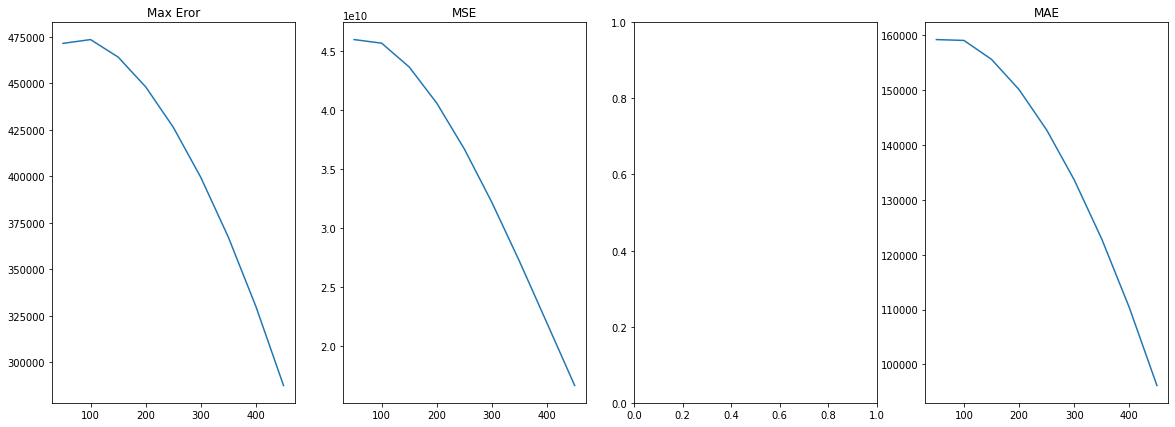

In [120]:
getStats("D:/SamplingResults2", "../Data/newSamples.pkl")

In [114]:
def getStat(runs):
    with open(f"samples.pkl", "rb") as f:
        samples = pickle.load(f)
    
    samples = np.array(samples[runs])
    
    df = pd.DataFrame({
        ("Skin", "YM"): samples[:, 0],
        ("Skin", "PR"): samples[:, 2],
        ("Skin", "Perm"): samples[:, 4],
        ("Adipose", "YM"): samples[:, 1],
        ("Adipose", "PR"): samples[:, 3],
        ("Adipose", "Perm"): samples[:, 5]
    })
    
    ranges = [
        [min(samples[:, 0]), max(samples[:, 0])], # Skin YM
        [min(samples[:, 1]), max(samples[:, 1])], # Adipose YM
        [min(samples[:, 2]), max(samples[:, 2])], # Skin PR
        [min(samples[:, 3]), max(samples[:, 3])], # Adipose PR
        [min(samples[:, 4]), max(samples[:, 4])], # Skin Perm
        [min(samples[:, 5]), max(samples[:, 5])],
    ]
    
    with open("sampleRanges.pkl", "wb") as f:
        pickle.dump(ranges, f)
    
    print(ranges)
    
    return df.describe()

# Save parameters for vis

In [69]:
with open("../Data/samples.pkl", "rb") as f:
    samples = pickle.load(f)

with open("../Data/newSamples.pkl", "rb") as f:
    newSamples = pickle.load(f)
    
# Get only uniques
allSamples = np.unique(np.concatenate([newSamples, samples]), axis=0)

with open("../Data/filtered.pkl", "rb") as f:
    filtered = pickle.load(f)

feasibleSamples = allSamples[filtered]

"""# Normalise
scaler = MinMaxScaler()
scaler.fit_transform(allSamples)
allSamples = scaler.transform(allSamples)
feasibleSamples = scaler.transform(feasibleSamples)"""

allSamples = [tuple(t) for t in allSamples]
feasibleSamples = [tuple(t) for t in feasibleSamples]
nonFeasibleSamples = list(set(allSamples)-set(feasibleSamples))

data = {}
s = np.concatenate([feasibleSamples, nonFeasibleSamples], axis=0)
for i in range(0, 6, 2):
    print(i)
    if i == 0:
        name = "Young's Modulus"
    elif i == 2:
        name = "Poissons Ratio"
    else:
        name = "Permeability"
    print(f'{name} (Skin) is', s[:, i][0])
    print(f'{name} (Adipose) is', s[:, i+1][0])
    data[f'{name} (Skin)'] = s[:, i]
    data[f'{name} (Adipose)'] = s[:, i+1]
data['Feasible'] = np.concatenate([np.repeat(True, len(feasibleSamples)), np.repeat(False, len(nonFeasibleSamples))], axis=0)

df = pd.DataFrame(
    data)

# Get means of each cluster for each column
for col in df.columns:
    if col == "Feasible":
        continue
    df[f"{col}_m"] = (df.assign(state=df[col])
                                      .groupby("Feasible")[col]
                                      .transform(lambda d: d.sum()/d.count()))
    
df.to_csv("../Vis/Data/parameters.csv")

0
Young's Modulus (Skin) is 11276.689618825912
Young's Modulus (Adipose) is 22242.815017700195
2
Poissons Ratio (Skin) is 0.4853868445754051
Poissons Ratio (Adipose) is 0.4953136205077171
4
Permeability (Skin) is 8.545776170492173e-10
Permeability (Adipose) is 9.387008649110794e-10


In [59]:
display(df.groupby("Feasible").describe())
display(df)
df.isnull().values.any()

Young's Modulus (Skin)                                        \
                          count      mean       std     min       25%   
Feasible                                                                
False                  128831.0  0.319455  0.281076  0.0000  0.105971   
True                     2241.0  0.105573  0.059922  0.0001  0.053656   

                                     Young's Modulus (Adipose)            ...  \
              50%       75%      max                     count      mean  ...   
Feasible                                                                  ...   
False     0.21189  0.508548  1.00000                  128831.0  0.501737  ...   
True      0.10587  0.157333  0.20821                    2241.0  0.502843  ...   

         Permeability (Skin)_m           Permeability (Adipose)_m            \
                           75%       max                    count      mean   
Feasible                                                                      
False                 0.473915  0.473915                 128831.0  0.500655   
True                  0.456299  0.456299                   2241.0  0.496265   

                                                                          
                   std       min       25%       50%       75%       max  
Feasible                                                                  
False     3.330682e-16  0.500655  0.500655  0.500655  0.500655  0.500655  
True      1.110471e-16  0.496265  0.496265  0.496265  0.496265  0.496265  

[2 rows x 96 columns]

,Young's Modulus (Skin),Young's Modulus (Adipose),Poissons Ratio (Skin),Poissons Ratio (Adipose),Permeability (Skin),Permeability (Adipose),Feasible,Young's Modulus (Skin)_m,Young's Modulus (Adipose)_m,Poissons Ratio (Skin)_m,Poissons Ratio (Adipose)_m,Permeability (Skin)_m,Permeability (Adipose)_m
0,0.031917,0.885117,0.283520,0.805988,0.853109,0.938084,True,0.105573,0.502843,0.439003,0.499297,0.456299,0.496265
1,0.032066,0.763646,0.325626,0.435236,0.848116,0.895381,True,0.105573,0.502843,0.439003,0.499297,0.456299,0.496265
2,0.032137,0.766096,0.633138,0.601950,0.065864,0.028622,True,0.105573,0.502843,0.439003,0.499297,0.456299,0.496265
3,0.032196,0.218696,0.663426,0.416424,0.640399,0.501712,True,0.105573,0.502843,0.439003,0.499297,0.456299,0.496265
4,0.032237,0.043454,0.765202,0.798523,0.320103,0.029650,True,0.105573,0.502843,0.439003,0.499297,0.456299,0.496265
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131067,0.014713,0.065272,0.040003,0.376622,0.398185,0.299796,False,0.319455,0.501737,0.465526,0.499975,0.473915,0.500655
131068,0.020210,0.802654,0.170483,0.902310,0.951847,0.999459,False,0.319455,0.501737,0.465526,0.499975,0.473915,0.500655
131069,0.121206,0.636671,0.830772,0.635215,0.818215,0.921709,False,0.319455,0.501737,0.465526,0.499975,0.473915,0.500655
131070,0.015748,0.611965,0.262192,0.745338,0.673644,0.151400,False,0.319455,0.501737,0.465526,0.499975,0.473915,0.500655


False

In [67]:
import numpy as np
from scipy.interpolate import interp1d

def calculate_interpolation_error(original_curve, interpolated_curve):
    # Create an interpolation function for the original curve
    f_original = interp1d(np.arange(len(original_curve)), original_curve, bounds_error=False)

    # Interpolate the original curve using the same method as the interpolated curve
    interpolated_original = interpolated_curve.copy()
    for i in range(len(interpolated_curve)):
        interpolated_original[i] = f_original(i)

    # Calculate the mean absolute error between the interpolated original and interpolated curves
    mae = np.mean(np.abs(interpolated_original - interpolated_curve))

    return mae


790 100
790 110
790 120
790 130
790 140
790 150
790 160
790 170
790 180
790 190
790 200
790 210
790 220
790 230
790 240
790 250
790 260
790 270
790 280
790 290
790 300
790 310
790 320
790 330
790 340
790 350
790 360
790 370
790 380
790 390
790 400
790 410
790 420
790 430
790 440
790 450
790 460
790 470
790 480
790 490
790 500
790 510
790 520
790 530
790 540
790 550
790 560
790 570
790 580
790 590
790 600
790 610
790 620
790 630
790 640
790 650
790 660
790 670
790 680
790 690
790 700
790 710
790 720
790 730
790 740
790 750
790 760
790 770
790 780
790 790


Text(0.5, 1.0, 'MAE')

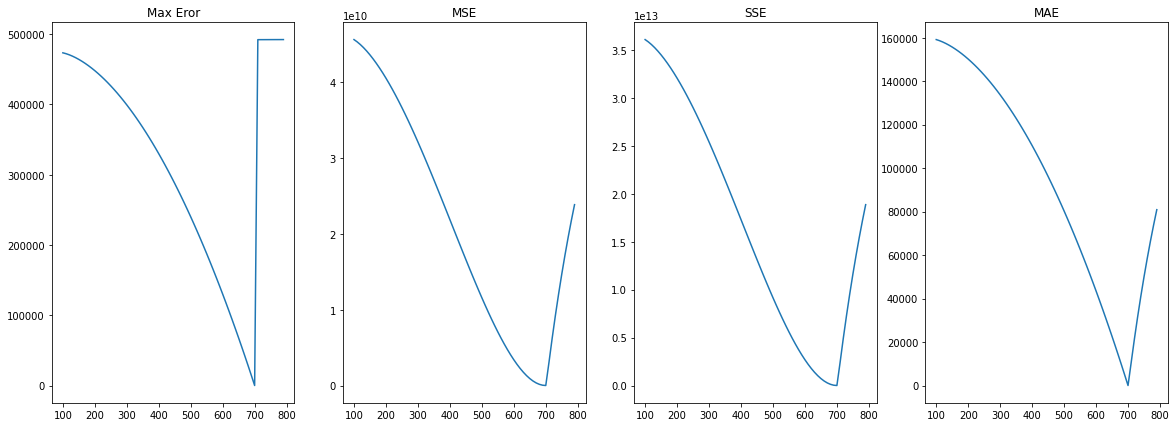

In [73]:
from sklearn.metrics import mean_squared_error
xs = np.array(list(range(701)))
ys = xs**2 + xs*5 + 2

me = []
mse = []
sse = []
mae = []
pts = range(100, 800, 10)
for steps in pts:
    # Interpolate curve for consistent x values
    xNew = np.linspace(0, 700, num=steps, endpoint=False)
    interped = interp1d(xs, ys, kind='cubic', fill_value="extrapolate")(xNew)
    
    # Create an interpolation function for the original curve
    f_original = interp1d(np.arange(len(ys)), ys, bounds_error=False)

    # Interpolate the original curve using the same method as the interpolated curve
    interpolated_original = interped.copy()
    for i in range(len(interped)):
        interpolated_original[i] = f_original(i)
    
    interpolated_original = np.nan_to_num(interpolated_original, 1e100)
    
    mse.append(mean_squared_error(interpolated_original, interped))
    sse.append(mse[-1]*len(orig))
    me.append(np.max(np.abs(interpolated_original - interped)))
    mae.append(np.mean(np.abs(interpolated_original - interped)))
    print(len(orig), len(interped))


fig, ax = plt.subplots(1, 4, figsize=(20, 7))
ax[0].plot(pts, me)
ax[0].set_title("Max Eror")
ax[1].plot(pts, mse)
ax[1].set_title("MSE")
ax[2].plot(pts, sse)
ax[2].set_title("SSE")
ax[3].plot(pts, mae)
ax[3].set_title("MAE")


In [48]:
me

[1.1641532182693481e-10,
 698.7499999999418,
 933.1111111112405,
 1045.3125000001164,
 1116.6400000000722,
 1168.194444444438,
 1.1641532182693481e-10]